Song, Shim, Rosenberg (2022) Large-scale neural dynamics in a shared low-dimensional state space reflect cognitive and attentional dynamics<br>
code created by: Hayoung Song (hyssong@uchicago.edu), March 27, 2022<br>

The code generates **Figure 2** of the paper

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import random
from statsmodels.stats.multitest import fdrcorrection
random.seed(1)

/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nsubj=27
nstate = 4
nROI = 25
loaddir='../'
condition=['rest1','rest2','gradCPTface','gradCPTscene','sitcomep1','sitcomep2','documentary']
cmap = np.array([[219 / 255, 68 / 255, 55 / 255, 1],
    [57 / 255, 0 / 255, 216 / 255, 1],
    [15 / 255, 157 / 255, 88 / 255, 1],
    [255 / 255, 215 / 255, 0 / 255, 1]])
statename = ['DMN','DAN','SM','base']

## Load gradient coefficients
Top-5 gradient values of cortical and subcortical voxels are downloaded from a repository. (Margulies et al., 2016; https://identifiers.org/neurovault.collection:1598) <br>
Applying 25 parcel mask, gradient values of every voxel within each parcel are averaged. <br>
Mean gradient values of 25 parcels are termed "gradient coefficients".

In [3]:
gradientcoeff = scipy.io.loadmat(loaddir+'fmri/gradientcoeff.mat')['gradientcoeff']
print('gradient coefficients: '+str(gradientcoeff.shape[0])+' parcel, '+str(gradientcoeff.shape[1])+' components')

gradient coefficients: 25 parcel, 5 components


## Situate latent states onto the gradient space (Figure 2b)

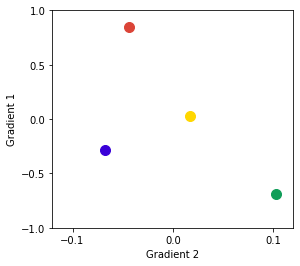

In [4]:
# Load mean activity patterns of 25 parcels inferred from the HMM fit
Means = scipy.io.loadmat(loaddir+'fmri/hmmmodel.mat')['Means']
# 4 latent state * 25 ROI mean activity patterns

# mean element-wise product of the HMM-inferred mean activity patterns and gradient coefficients
fig = plt.figure()
ax = fig.add_subplot(111)
for stt in range(nstate):
    plt.scatter(np.mean(np.multiply(Means[stt,:], gradientcoeff[:,1]))*(-1), 
                np.mean(np.multiply(Means[stt,:], gradientcoeff[:,0])),
                s=100,c=cmap[stt,:].reshape(1,-1))
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-1,1])
ax.set_xticks([-0.1,0,0.1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_ylabel('Gradient 1')
ax.set_xlabel('Gradient 2')
plt.show()

## Compare gradient & PC coefficients (Figure 2c)

In [5]:
concatts = []
for cdt in condition:
    # Load time series
    ts = scipy.io.loadmat(loaddir+'fmri/ts_'+cdt+'.mat')['ts']

    for subj in range(nsubj):
        if cdt=='sitcomep1' and subj==25:
            pass
        else:
            # z-normalize across time
            ts_subj = scipy.stats.zscore(ts[subj,:,:], axis=0, ddof=1)
            if len(concatts)==0:
                concatts = ts_subj
            else:
                # concatenate all participants' all fMRI run time series
                concatts = np.concatenate((concatts, ts_subj),0)
print('concatenated time series: '+str(concatts.shape[0])+' x '+str(concatts.shape[1]))

concatenated time series: 170936 x 25


In [6]:
# Conduct PCA on the z-normalized, concatenated time series
ncomp = 5
pca = PCA(n_components=ncomp)
score = pca.fit_transform(concatts)
coeff = pca.components_

# Pearson's correlation between gradient coefficients and PC coefficients
for comp in range(ncomp):
    print('grad'+str(comp+1)+' - PC'+str(comp+1)+': r = '+str(np.round(np.abs(np.corrcoef(gradientcoeff[:,comp], coeff[comp,:])[0,1]),3)))

grad1 - PC1: r = 0.896
grad2 - PC2: r = 0.672
grad3 - PC3: r = 0.696
grad4 - PC4: r = 0.815
grad5 - PC5: r = 0.05


## Explained variance (Figure 2d)

In [7]:
grad_expvar, pc_expvar = [], []
for cdt in condition:
    # Load time series
    ts = scipy.io.loadmat(loaddir+'fmri/ts_'+cdt+'.mat')['ts']
    for subj in range(nsubj):
        if cdt=='sitcomep1' and subj==25:
            pass
        else:
            # z-normalize across time
            ts_subj = scipy.stats.zscore(ts[subj,:,:], axis=0, ddof=1)
            
            # time course projected onto gradient 5D space
            grad = []
            for t in range(ts_subj.shape[0]):
                grad.append([np.mean(np.multiply(ts_subj[t,:], gradientcoeff[:,0])),
                             np.mean(np.multiply(ts_subj[t,:], gradientcoeff[:,1])),
                             np.mean(np.multiply(ts_subj[t,:], gradientcoeff[:,2])),
                             np.mean(np.multiply(ts_subj[t,:], gradientcoeff[:,3])),
                             np.mean(np.multiply(ts_subj[t,:], gradientcoeff[:,4]))])
            grad = np.array(grad)
            
            # time course projected onto PC 5D space
            score = pca.transform(ts_subj)
            
            # r-sq between 25 ROI fMRI ts and gradient/pc ts
            grad_rsq, pc_rsq = np.zeros((nROI, ncomp)), np.zeros((nROI, ncomp))
            for comp in range(ncomp):
                for net in range(nROI):
                    pc_rsq[net, comp] = np.square(np.corrcoef(ts_subj[:,net], score[:,comp])[0,1])
                    grad_rsq[net, comp] = np.square(np.corrcoef(ts_subj[:,net], grad[:,comp])[0,1])
            grad_expvar.append(np.mean(grad_rsq,0))
            pc_expvar.append(np.mean(pc_rsq,0))
pc_expvar, grad_expvar = np.array(pc_expvar), np.array(grad_expvar)

PC: [0.17660356 0.12385367 0.11615556 0.09095416 0.07739281]
Gradient: [0.16901735 0.10952305 0.11179565 0.0986039  0.09269885]
Diff: [ 0.00758621  0.01433063  0.00435992 -0.00764974 -0.01530605]


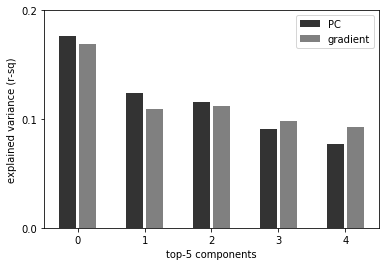

In [8]:
# bar graph of top-5 components' explained variances
print('PC: '+str(np.mean(pc_expvar,0)))
print('Gradient: '+str(np.mean(grad_expvar,0)))
print('Diff: '+str(np.mean(pc_expvar,0)-np.mean(grad_expvar,0)))
plt.bar(np.arange(ncomp)-0.15, np.mean(pc_expvar,0), color = [0.2,0.2,0.2,1], width = 0.25)
plt.bar(np.arange(ncomp)+0.15, np.mean(grad_expvar,0), color = [0.5,0.5,0.5,1], width = 0.25)
plt.ylim([0,0.2])
plt.yticks([0,0.1,0.2])
plt.ylabel('explained variance (r-sq)')
plt.xlabel('top-5 components')
plt.legend({'PC','gradient'})
plt.show()

In [9]:
# Paired t-tests between explained variances of the PC and gradient components
pvals = []
for comp in range(ncomp):
    pvals.append(scipy.stats.ttest_rel(pc_expvar[:,comp], grad_expvar[:,comp])[1])

# FDR-correction for number of comparisons (5 components)
qvals = fdrcorrection(np.array(pvals))[1]

for comp in range(ncomp):
    print('component '+str(comp+1)+': t('+str(pc_expvar.shape[0]-1)+')='+
          str(np.round(scipy.stats.ttest_rel(pc_expvar[:,comp], grad_expvar[:,comp])[0],3))+
      ', FDR-p='+str(np.round(qvals[comp],4)))

component 1: t(187)=12.862, FDR-p=0.0
component 2: t(187)=12.99, FDR-p=0.0
component 3: t(187)=3.022, FDR-p=0.0029
component 4: t(187)=-6.631, FDR-p=0.0
component 5: t(187)=-8.136, FDR-p=0.0
